### Loading dependecies


In [54]:
%matplotlib inline

import aylien_news_api
from aylien_news_api.rest import ApiException
import pandas as pd
import matplotlib.pyplot as plt
import sys
import datetime
import numpy as np

### Global script configs

In [58]:
# start and end of period
start = "NOW-300DAY"
end = "NOW"
# summarize key. possible values = day, week, month
summarize = "week"
# count of parts to split each bucket (for weighted average)
weight_steps = 4
# AYLIEN News API keys
aylien_news_api.configuration.api_key['X-AYLIEN-NewsAPI-Application-ID'] = ''
aylien_news_api.configuration.api_key['X-AYLIEN-NewsAPI-Application-Key'] = ''

### Main() { ... }

fetching data...
skipping... Tuesday at 9
skipping... Wednesday at 9
skipping... Thursday at 9
skipping... Friday at 9
skipping... Saturday at 9
skipping... Sunday at 9
skipping... Tuesday at 9
skipping... Wednesday at 9
skipping... Thursday at 9
skipping... Friday at 9
skipping... Saturday at 9
skipping... Sunday at 9
score array: [29, 0, 0, 11]
score array: [29, 0, 0, 11]
score array: [29, 0, 0, 11]
score array: [28, 0, 1, 11]
score array: [28, 0, 0, 12]
score array: [28, 0, 0, 12]
score array: [28, 0, 0, 12]


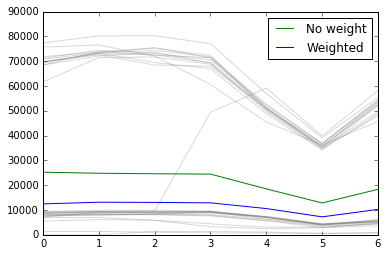

In [55]:
if (summarize == "month"):
    period = "+1DAY"
    chunks = 30
elif (summarize == "week"):
    period = "+1DAY"
    chunks = 7
elif (summarize == "day"):
    period = "+1HOUR"
    chunks = 24
else:
    print('Invalid summarize value')
    sys.exit(0)

api_instance = aylien_news_api.DefaultApi()

try: 
    print('fetching data...')
    
    # List time series
    api_response = api_instance.list_time_series(published_at_start = start, 
                                                 published_at_end = end, 
                                                 period = period)
    
    data = api_response.time_series
    chunk = [0] * chunks
    tmp_chunk = [0] * chunks
    history_tmp_chunks = []
    i = 0
    i_total = 0
    skip = True
    
    for d in data:
        # EST timezone
        d.published_at = d.published_at - datetime.timedelta(hours=+5)
        
        # we should start adding values when we are on the first member of our series
        # e.g. if the summarize is weekly, we should start adding values on Monday
        # e.g. if the summzrize is daily, we should start adding values when it's 00:00
        if (summarize == "week" and d.published_at.strftime("%A") == 'Monday'):
            skip = False
        elif (summarize == "day" and 
              d.published_at.hour == 0):
            skip = False
        elif (summarize == "month"  and d.published_at.day == 1):
            skip = False
        
        
        # also, we should skip adding values if don't have enough members left to add (based on chunk size)
        if (data.index(d) + chunks > len(data)):
            skip = True
        
        if skip:
            print('skipping...', d.published_at.strftime('%A'), 'at ' + str(d.published_at.hour))
            continue
            
        if (i == chunks):
            plt.plot(tmp_chunk, color='gray', alpha=0.3)
            i = 0
            i_total += 1
            history_tmp_chunks.append(tmp_chunk[:])
            
            
        chunk[i] += d.count
        tmp_chunk[i] = d.count
        
        i += 1
        
    weighted_col = []
    # calculating the weight
    for w in range(chunks):
        col = np.array(history_tmp_chunks)[:, w]
        col_min, col_max = min(col), max(col)
        step_val = (col_max - col_min) / weight_steps
        
        # because the col_min is only the first element of steps
        steps = [col_min]
        
        # the score of each step
        steps_score = [0] * weight_steps
        
        # preparing the `steps` array 
        for step in range(weight_steps):
            steps.append(steps[-1] + step_val)
                
        for i in range(len(col)):
            for j in range(len(steps)):
                
                if j == 0:
                    continue
                
                if steps[j - 1] <= col[i] < steps[j]:
                    steps_score[j - 1] += 1
        
        weighted_col_tmp = []
        weighted_col_sum = []
        for i in range(len(col)):
            for j in range(len(steps)):
                
                if steps[j - 1] <= col[i] < steps[j]:
                    weighted_col_tmp.append(col[i] * steps_score[j - 1])
                    weighted_col_sum.append(steps_score[j - 1])

        weighted_col.append(np.sum(weighted_col_tmp) / np.sum(weighted_col_sum))
        
        print('score array:', steps_score)
    
    
    weighted, = plt.plot(weighted_col, label='Weighted')
    
    j = 0
    for c in chunk:
        if (chunk[j] != 0):
            chunk[j] = c / i_total
            
        j += 1
        
    no_weight, = plt.plot(chunk, label='No weight')
    
    plt.legend(handles=[no_weight, weighted])

        
except ApiException as e:
    print("Exception when calling DefaultApi->list_time_series: %s\n" % e)
